# 0. Introduction to alea: a simple Gaussian model
Welcome to alea: a Python package designed for constructing, handling, and fitting statistical models, computing confidence intervals and conducting sensitivity studies. Developed by the [XENON collaboration](https://xenonexperiment.org/), our aim is to provide an intuitive and flexible framework for statistical analysis.

In this tutorial, you'll get to know alea by starting with a basic yet fundamental model: the Gaussian.
We'll walk through model setup, data generation, and model fitting using generated data. This hands-on example will help you grasp the core concepts of alea and set you on the path to harnessing its capabilities for your own analyses. Let's dive in!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from alea import GaussianModel

In [2]:
# Just some plotting settings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [4, 3]
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

## 0.1 Define the model

The simplest way to get started to just initialize a default `GaussianModel` without specifying anything else:

In [3]:
model = GaussianModel()

The instance `model` isn't of much use for now as we haven't specified anything. Let's have a look at the parameters of the model:

In [4]:
model.parameters

alea.parameters.Parameters(mu, sigma)

We can see that we have a parameter `mu`, which corresponds to the mean of the normal distribution, and a parameter `sigma`, which corresponds to its standard deviation. To learn more about the two parameters we can look at them individually:

In [5]:
model.parameters.mu

alea.parameters.Parameter(name=mu, fittable=True)

In [6]:
model.parameters.sigma

alea.parameters.Parameter(name=sigma, fittable=True)

As we can see, right now, the only defined properties of both parameters are their names and whether they are fittable. Let's give the parameters nominal values and see what happens:

In [7]:
model.parameters.mu.nominal_value = 1.
model.parameters.sigma.nominal_value = .1

In [8]:
model.parameters.mu

alea.parameters.Parameter(name=mu, nominal_value=1.0, fittable=True)

In [9]:
model.parameters.sigma

alea.parameters.Parameter(name=sigma, nominal_value=0.1, fittable=True)

## 0.2 Generate data from the model

This information is enough for the model to generate some data. Let's see what we can do:

In [10]:
data = model.generate_data()
data

[array([(1.07207822,)], dtype=[('hat_mu', '<f8')])]

You can see that the data is a single value called `'hat_mu'`, which corresponds to a single measurement of a Gaussian distributed random variable. Note that the result is a list of a structured array. This becomes important when we have a model with multiple components. For now, we can ignore it and always just consider the first (and only) entry.

Let's visualize the toy data generation by conducting 1000 experiments and plotting the distribution of the 'observed' data:

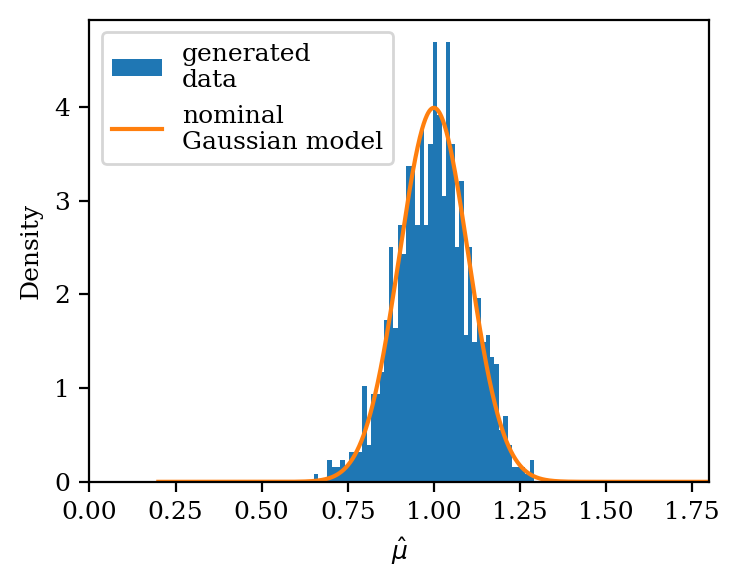

In [11]:
# Run the toy experiments
datas = []
for i in range(1000):
    data = model.generate_data()
    datas.append(data[0]["hat_mu"][0])


# Visualize the distribution of the data and compare it to the nominal model
plt.hist(datas, bins=50, density=True, label="generated\ndata")
x = np.linspace(.2, 1.8, 1000)
plt.plot(x, stats.norm.pdf(x,
                           loc=model.parameters.mu.nominal_value,
                           scale=model.parameters.sigma.nominal_value),
         label="nominal\nGaussian model")

# Cosmetics
plt.xlim(0, 1.8)
plt.xlabel(r"$\hat{\mu}$")
plt.ylabel("Density")
plt.legend(loc = 'upper left')

plt.show()

We can also change parameters in the data generation without modifying their nominal values by simply specifying them in the `generate_data` method. For example, we could generate data distributed around a mean of 0 instead of the nominal value of 0:

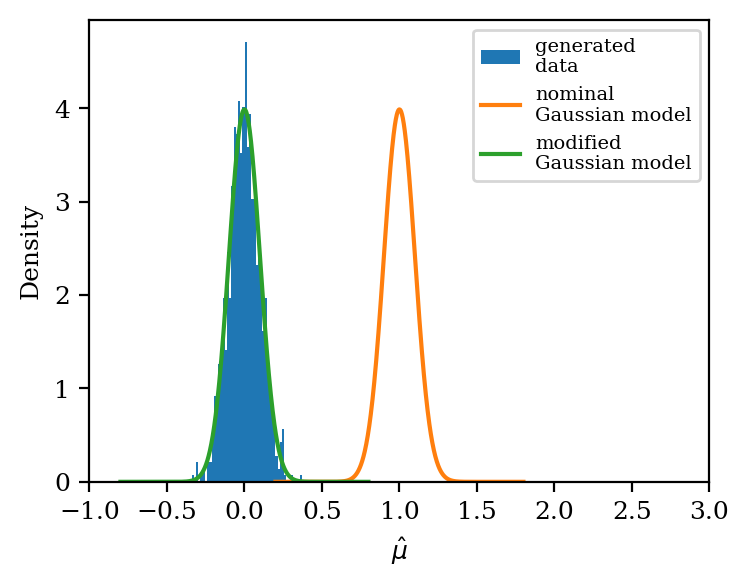

In [12]:
# Run the toy experiments
datas = []
for i in range(1000):
    data = model.generate_data(mu=0)
    datas.append(data[0]["hat_mu"][0])


# Visualize the distribution of the data and compare it to the nominal model
plt.hist(datas, bins=50, density=True, label="generated\ndata")
x = np.linspace(.2, 1.8, 1000)
plt.plot(x, stats.norm.pdf(x,
                           loc=model.parameters.mu.nominal_value,
                           scale=model.parameters.sigma.nominal_value),
         label="nominal\nGaussian model")
x = np.linspace(-.8, .8, 1000)
plt.plot(x, stats.norm.pdf(x,
                           loc=0,
                           scale=model.parameters.sigma.nominal_value),
         label="modified\nGaussian model")

# Cosmetics
plt.xlabel(r"$\hat{\mu}$")
plt.ylabel("Density")
plt.legend(loc = 'upper right', fontsize=7)
plt.xlim(-1, 3)

plt.show()

You can verify that the nominal values are unchanged:

In [13]:
model.parameters.nominal_values

{'mu': 1.0, 'sigma': 0.1}

## 0.3 Fit the model to data

Now that we know how to generate data from the model we can assign it to the model and then find the parameters that maximize the likelihood.

In [14]:
# generate data from the nominal model
data = model.generate_data()

# Assign the data to the model
model.data = data

Now we want to perform the fit but we're only interested in the `mu` parameter, so we fix `sigma`:

In [15]:
model.parameters.sigma.fittable = False

In [16]:
best_fit, max_ll = model.fit()
best_fit

{'mu': 1.188169724999197, 'sigma': 0.1}

Let's visualize the likelihood minimization. We can access the log-likelihood of the model at a given value `x` of `mu` via `model.ll(mu=x)`. 

Text(0, 0.5, 'Log Likelihood Ratio')

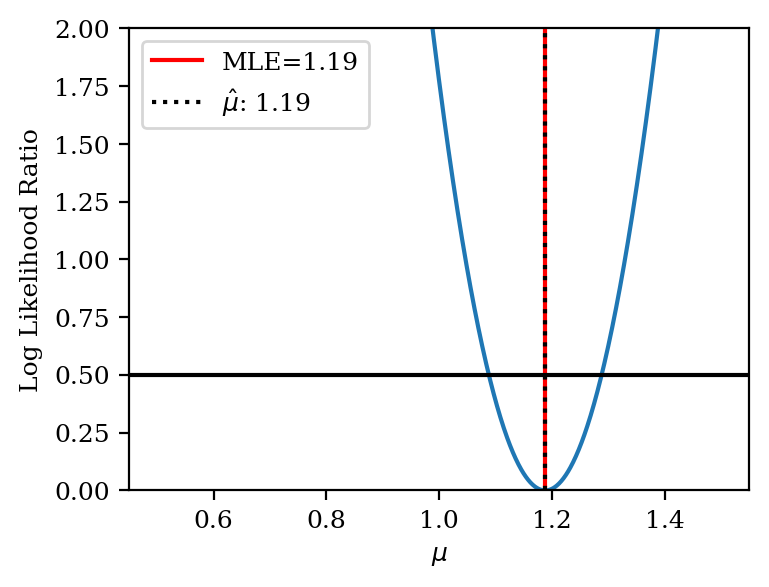

In [17]:
# Evaluate the log-likelihood at different values x of mu
x = np.linspace(0.5, 1.5, 1000)
y = - model.ll(mu=x)
# Compute log-likelihood ratio
y -=  min(y)
mle = best_fit["mu"]

# Plot
plt.plot(x, y)
plt.axvline(mle, label=f"MLE={mle:.2f}", color="red")
plt.axvline(model.data[0]["hat_mu"][0],
            label=f"$\hat{{\mu}}$: {model.data[0]['hat_mu'][0]:.2f}",
            ls=":", color="k")

# Cosmetics
plt.axhline(.5, c="k")
plt.ylim(0, 2)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("Log Likelihood Ratio")

## 0.4 Alternative model configuration

Above, we configured the model step by step. However, there is also the option to directly configure the model parameters in the initialization:

In [18]:
parameter_definition = {
    'mu': {
        'fittable': True,
        'nominal_value': 0.,
    },
    'sigma': {
        'fittable': False,
        'nominal_value': 1.,
    },
}

model = GaussianModel(parameter_definition=parameter_definition)
model.generate_data()

[array([(-0.92020393,)], dtype=[('hat_mu', '<f8')])]